In [1]:
# Importing packages
import numpy as np
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col, lower, regexp_replace, desc, explode

spark = SparkSession.builder\
        .master("spark://192.168.2.157:7077") \
        .appName("Analysis")\
        .config("spark.executor.cores", 8)\
        .config("spark.executor.memory", "10g")\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()
sc = spark.sparkContext

# Adjusting the log messages 
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/15 17:18:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load the dataset
df = spark.read.json("hdfs://192.168.2.157:9000/user/ubuntu/input/corpus-webis-tldr-17.json").persist()

In [3]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# Clean 'content' by removing non-alphabetic characters
df = df.withColumn("cleaned_content", lower(regexp_replace("content", "[^a-zA-Z\\s]", "")))

# Tokenize cleaned content
tokenizer = Tokenizer(inputCol="cleaned_content", outputCol="content_tokens")
df = tokenizer.transform(df)

# Remove stop words
remover = StopWordsRemover(inputCol="content_tokens", outputCol="filtered_content_tokens")
df = remover.transform(df)


In [4]:
# Identifying Top 10 Subreddits
top_subreddits = df.groupBy("subreddit").count().orderBy(desc("count")).limit(10)
top_subreddits.show()


+-------------------+------+
|          subreddit| count|
+-------------------+------+
|          AskReddit|589947|
|      relationships|352049|
|    leagueoflegends|109307|
|               tifu| 52219|
|relationship_advice| 50416|
|              trees| 47286|
|             gaming| 43851|
|            atheism| 43268|
|      AdviceAnimals| 40783|
|              funny| 40171|
+-------------------+------+



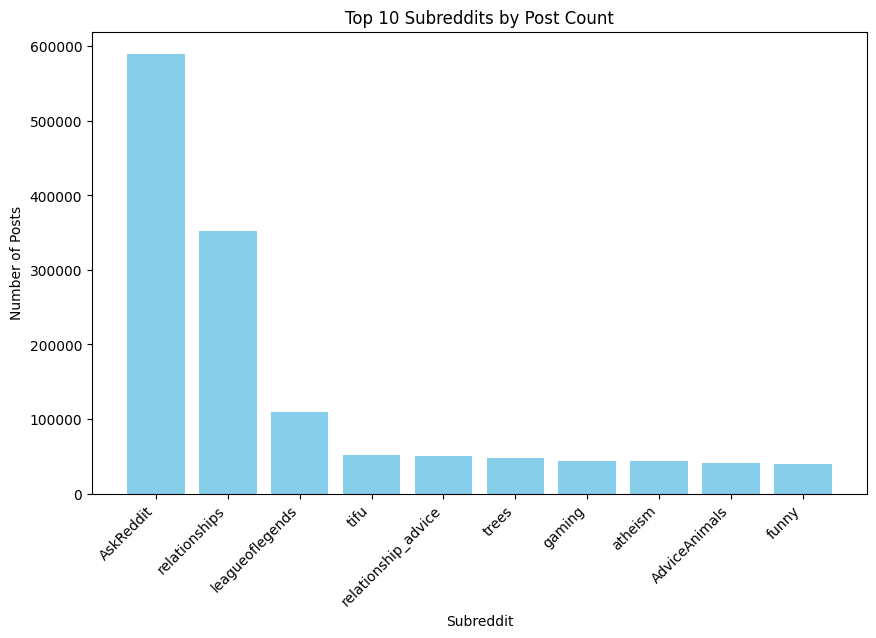

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

top_subreddits_pd = top_subreddits.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_subreddits_pd['subreddit'], top_subreddits_pd['count'], color='skyblue')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Subreddits by Post Count')
plt.show()

In [8]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql import Row
from pyspark.sql.functions import lit
import pandas as pd

# List to hold word frequency dataframes
subreddit_keywords_list = []

for subreddit_name in top_subreddits_pd['subreddit']:
    subreddit_df = df.filter(col("subreddit") == subreddit_name)
    word_frequencies = subreddit_df.withColumn("word", explode("filtered_content_tokens"))\
                               .filter(col("word") != "") \
                               .groupBy("word").count()\
                               .orderBy(desc("count"))\
                               .limit(20)
    
    # Add a subreddit column for identification
    word_freq_with_subreddit = word_frequencies.withColumn("subreddit", lit(subreddit_name))
    
    # Collect to Python list of Rows
    collected_data = word_freq_with_subreddit.collect()
    
    # Append to our list
    subreddit_keywords_list += collected_data

# Convert list of Rows into a Spark DataFrame
subreddit_keywords_schema = StructType([
    StructField("word", StringType(), True),
    StructField("count", IntegerType(), True),
    StructField("subreddit", StringType(), True)
])

subreddit_keywords_df = spark.createDataFrame(subreddit_keywords_list, schema=subreddit_keywords_schema)

# Convert to Pandas DataFrame
subreddit_keywords_pd = subreddit_keywords_df.toPandas()

# Display the DataFrame
print(subreddit_keywords_pd.head())


   word   count  subreddit
0   one  500879  AskReddit
1  like  452404  AskReddit
2   get  437855  AskReddit
3    im  393625  AskReddit
4  time  386126  AskReddit


In [9]:
import matplotlib.pyplot as plt

# Visualization function
def visualize_top_keywords(subreddit_name):
    data = subreddit_keywords_pd[subreddit_keywords_pd['subreddit'] == subreddit_name]
    plt.figure(figsize=(10, 8))
    plt.barh(data['word'], data['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Keywords')
    plt.title(f'Top Keywords in {subreddit_name}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
    plt.show()

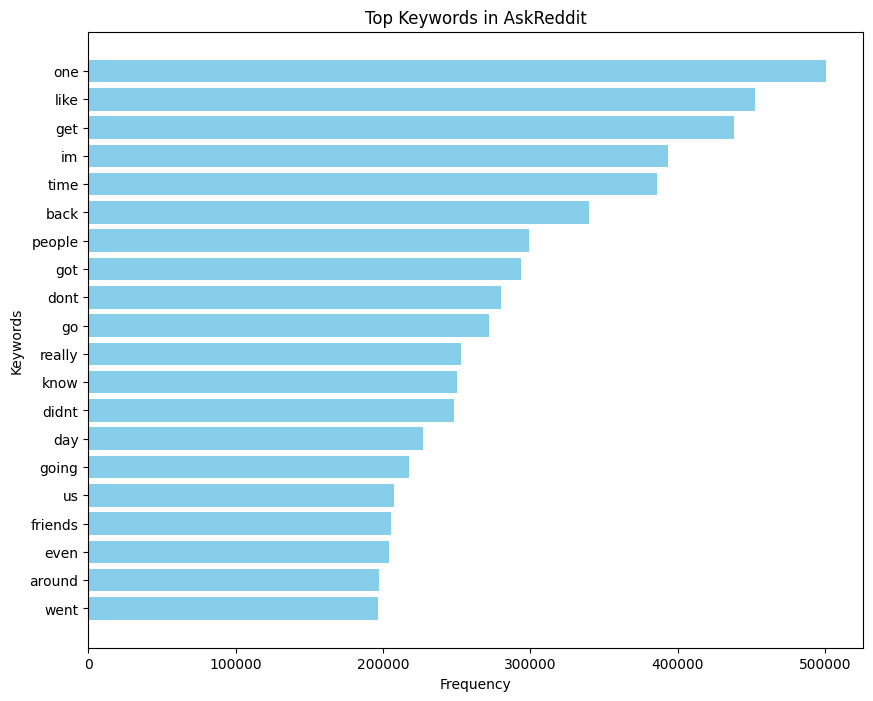

In [13]:
# Example: Visualize for one subreddit
visualize_top_keywords(top_subreddits_pd['subreddit'][0])

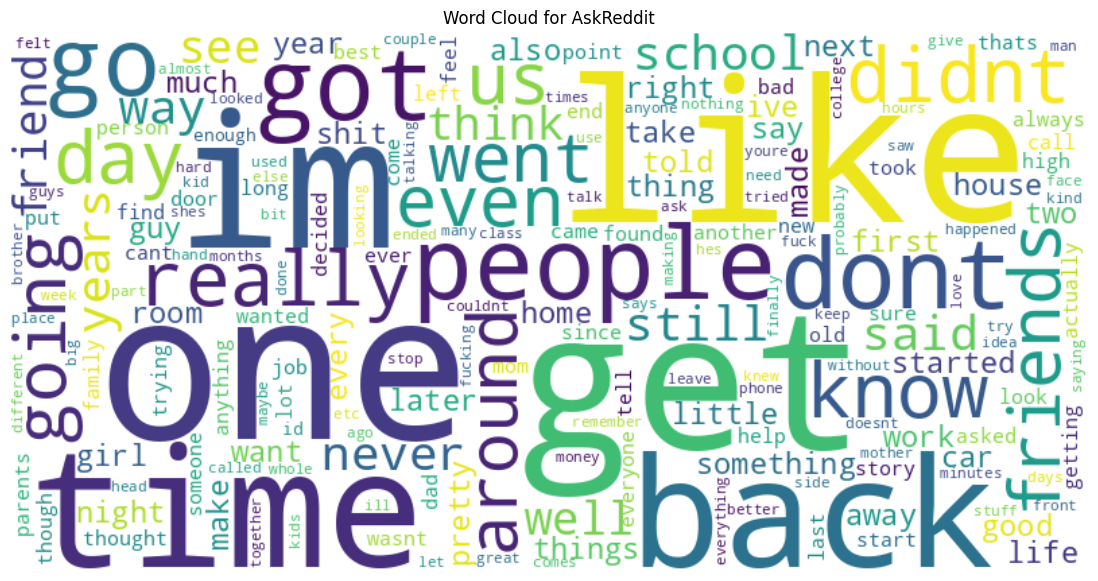

In [14]:
from wordcloud import WordCloud

# Example for the first subreddit in the top 10 list
subreddit_name = top_subreddits_pd['subreddit'][0]

subreddit_df = df.filter(col("subreddit") == subreddit_name)
words = subreddit_df.withColumn("word", explode("filtered_content_tokens")).groupBy("word").count().toPandas()

word_freq = dict(zip(words['word'], words['count']))
word_cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.title(f'Word Cloud for {subreddit_name}')
plt.show()


In [15]:
spark.stop()